In [1]:
from scipy.optimize import least_squares, minimize, BFGS
import numpy as np
import matplotlib.pyplot as plt
from toy_datasets import ToyDatasets
from scipy.stats import norm
%matplotlib inline

In [15]:
class Stage4Algorithm():
  def __init__(self, num_elements, h_order, ar_order, normalize=True):
    self.num_elements = num_elements
    self.h_order, self.ar_order = h_order, ar_order
    self.X, self.G, self.K = None, None, None
    self.dims = None
    self.normalize = normalize

  def hankelise(self, x, order):
    hankel_matrix = np.zeros((order, x.shape[1] - order + 1))
    for i in range(order):
      hankel_matrix[i, :] = x[0, i:i+x.shape[1]-order+1]
    return hankel_matrix

  def objective(self, params):
    (X_shape, X_len), (G_shape, G_len), (K_shape, K_len) = self.dims
    X, G = params[:X_len], params[X_len:(X_len+G_len)]
    X, G = X.reshape(X_shape), G.reshape(G_shape)
    result = 0.5 * np.linalg.norm(G, 'fro') ** 2
    return result

  def hankel_constraint(self, params):
    (X_shape, X_len), (G_shape, G_len), (K_shape, K_len) = self.dims
    X, K_t = params[:X_len], params[(X_len+G_len):]
    X, K_t = X.reshape(X_shape), K_t.reshape(K_shape)
    K = self.K
    K[-1:] = K_t
    X1, X2 = X[:, :-1], X[:, 1:]
    X1, X2 = self.hankelise(X1, self.ar_order), self.hankelise(X2, self.ar_order)
    return (X2 - K @ X1).flatten()

  def D_constraint(self, params, D):
    (X_shape, X_len), (G_shape, G_len), (K_shape, K_len) = self.dims
    X, G = params[:X_len], params[X_len:(X_len+G_len)]
    X, G = X.reshape(X_shape), G.reshape(G_shape)
    return (D - X - G).flatten()
    
  def fit(self, D):
    X_initial_guess, G_initial_guess, K_initial_guess = \
      D, np.random.normal(0, 0.01, D.shape), np.zeros((1, self.ar_order))

    if self.normalize:
      min_val, max_val = D.min(axis=1).reshape(-1, 1), D.max(axis=1).reshape(-1, 1)
      self.min_val, self.max_val = min_val, max_val
      D = (D - min_val) / (max_val - min_val)
      X_initial_guess = (X_initial_guess - min_val) / (max_val - min_val)
      G_initial_guess = G_initial_guess / (max_val - min_val)

    params = np.concatenate([X_initial_guess.flatten(), G_initial_guess.flatten(), K_initial_guess.flatten()])
    dims = (
      (X_initial_guess.shape, len(X_initial_guess.flatten())),
      (G_initial_guess.shape, len(G_initial_guess.flatten())),
      (K_initial_guess.shape, len(K_initial_guess.flatten()))
    )
    self.dims = dims

    K = np.zeros((self.ar_order, self.ar_order))
    rows, cols = np.diag_indices(self.ar_order - 1)
    K[rows, cols + 1] = 1
    self.K = K

    constraints = (
      {'type': 'eq', 'fun': self.hankel_constraint},
      {'type': 'eq', 'fun': self.D_constraint, 'args': (D,)},
    )
    options = {
      'disp': True,
      'maxiter': 1000,
      'gtol': 1e-6,
      'xtol': 1e-6
    }
    result = minimize(self.objective, params, constraints=constraints, method='trust-constr', jac='2-point', hess=BFGS(), options=options)
    (X_shape, X_len), (G_shape, G_len), (K_shape, K_len) = self.dims
    X, G, K = result.x[:X_len], result.x[X_len:(X_len+G_len)], result.x[(X_len+G_len):]
    X, G, K = X.reshape(X_shape), G.reshape(G_shape), K.reshape(K_shape)

    if self.normalize:
      X, G = X * (max_val - min_val) + min_val, G * (max_val - min_val)

    self.X, self.G, self.K = X, G, K

  def predict(self, x):
    y_predicted = []
    for i in range(x.shape[1] - self.ar_order):
      y_predicted.append(np.dot(x.flatten()[i:i+self.ar_order], self.K).flatten()[0])
    return y_predicted

  def forecast(self, x, timesteps):
    if self.normalize:
      x = (x - self.min_val) / (self.max_val - self.min_val)
    current_window = x[:, -(self.ar_order+1)+1:]
    forecasted = np.zeros((1, timesteps))
    idx_ravel = (np.arange(self.ar_order)[:, None] + np.arange(current_window.shape[1] - self.ar_order + 1)).ravel()
    for i in range(timesteps):
      hankel_window = current_window[:, idx_ravel].reshape(self.ar_order, -1)
      next_el = (self.K @ hankel_window)[:, -1]
      forecasted[:, i] = next_el
      current_window = np.hstack((current_window, next_el.reshape(-1, 1)))[:, 1:]
    if self.normalize:
      forecasted = forecasted * (self.max_val - self.min_val) + self.min_val
    return forecasted
  
  def evaluate(self, y, y_predicted):
    return np.sqrt(1/len(y) * np.sum(np.square(y - y_predicted)))

`xtol` termination condition is satisfied.
Number of iterations: 13, function evaluations: 1288, CG iterations: 0, optimality: 2.72e-02, constraint violation: 1.11e-16, execution time: 0.78 s.
Gaussian Noise fit MSE:  1.251459555495227
Gaussian Noise forecast MSE:  1.12485392954241
`xtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 1472, CG iterations: 0, optimality: 1.60e-02, constraint violation: 2.22e-16, execution time: 0.81 s.
Non-Gaussian Noise fit MSE:  3.9873317456305406
Non-Gaussian Noise forecast MSE:  2.6961333848145297
`xtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 1656, CG iterations: 0, optimality: 6.20e-02, constraint violation: 1.11e-16, execution time:  0.7 s.
Both Noise fit MSE:  4.449679811810548
Both Noise forecast MSE:  4.270290938038179


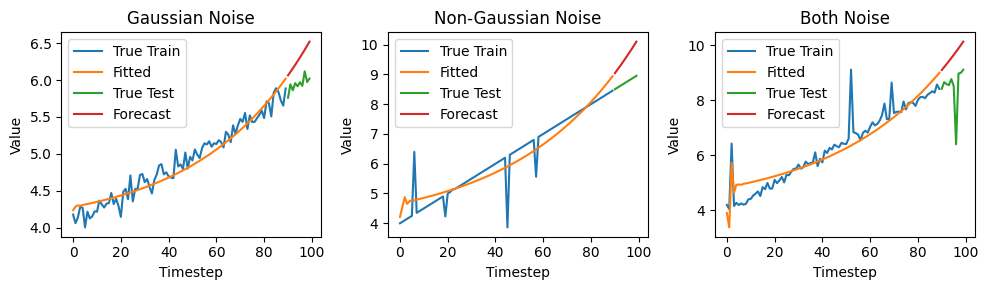

In [19]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 1, 3, 10
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)

datasets = [
  ("Gaussian Noise", toy_datasets.linear_trending_with_gaussian_noise().reshape(-1, 1).T), 
  ("Non-Gaussian Noise", toy_datasets.linear_trending_with_non_gaussian_noise().reshape(-1, 1).T),
  ("Both Noise", toy_datasets.linear_trending_with_both_noise().reshape(-1, 1).T),
]
fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(10, 3))
for i, (title, ds) in enumerate(datasets):
  train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

  alg = Stage4Algorithm(num_elements=num_elements, h_order=20, ar_order=order,)
  alg.fit(train_data)
  fitted = alg.X
  forecasted = alg.forecast(fitted, test_len)
  ax[i].plot(range(train_data.shape[1]), train_data.flatten(), label="True Train")
  ax[i].plot(range(train_data.shape[1]), fitted.T, label="Fitted")
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.flatten(), label="True Test")
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
  ax[i].set_xlabel("Timestep")
  ax[i].set_ylabel("Value")
  ax[i].set_title(title)
  ax[i].legend()

  fit_mse = alg.evaluate(train_data, alg.X)
  print(f"{title} fit MSE: ", fit_mse)
  forecast_mse = alg.evaluate(test_data, forecasted)
  print(f"{title} forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:80: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:203: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)


`xtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 1656, CG iterations: 0, optimality: 1.32e-02, constraint violation: 8.88e-16, execution time:  2.7 s.
Gaussian Noise fit MSE:  0.9012555664225147
Gaussian Noise forecast MSE:  0.1968216259639351
`xtol` termination condition is satisfied.
Number of iterations: 17, function evaluations: 1840, CG iterations: 0, optimality: 2.09e-01, constraint violation: 1.78e-15, execution time:  2.5 s.
Non-Gaussian Noise fit MSE:  3.4446789119251373
Non-Gaussian Noise forecast MSE:  0.8962052390115647
`xtol` termination condition is satisfied.
Number of iterations: 18, function evaluations: 2024, CG iterations: 0, optimality: 3.31e+00, constraint violation: 8.88e-16, execution time: 0.96 s.
Both Noise fit MSE:  3.8811728532217926
Both Noise forecast MSE:  3.0224779803361


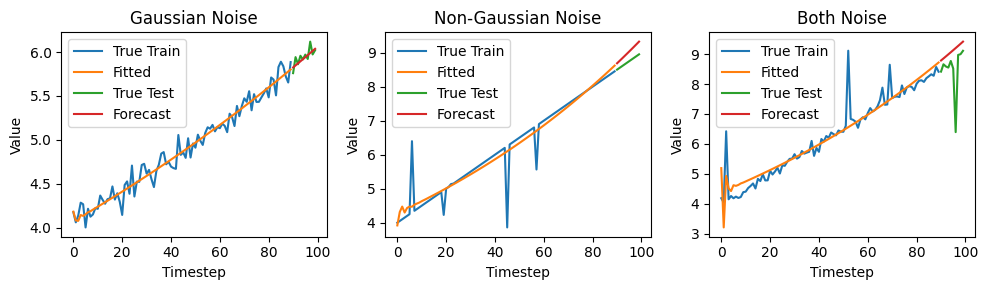

In [20]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 1, 3, 10
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)

datasets = [
  ("Gaussian Noise", toy_datasets.linear_trending_with_gaussian_noise().reshape(-1, 1).T), 
  ("Non-Gaussian Noise", toy_datasets.linear_trending_with_non_gaussian_noise().reshape(-1, 1).T),
  ("Both Noise", toy_datasets.linear_trending_with_both_noise().reshape(-1, 1).T),
]
fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(10, 3))
for i, (title, ds) in enumerate(datasets):
  train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

  alg = Stage4Algorithm(num_elements=num_elements, h_order=20, ar_order=order, normalize=False)
  alg.fit(train_data)
  fitted = alg.X
  forecasted = alg.forecast(fitted, test_len)
  ax[i].plot(range(train_data.shape[1]), train_data.flatten(), label="True Train")
  ax[i].plot(range(train_data.shape[1]), fitted.T, label="Fitted")
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.flatten(), label="True Test")
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
  ax[i].set_xlabel("Timestep")
  ax[i].set_ylabel("Value")
  ax[i].set_title(title)
  ax[i].legend()

  fit_mse = alg.evaluate(train_data, alg.X)
  print(f"{title} fit MSE: ", fit_mse)
  forecast_mse = alg.evaluate(test_data, forecasted)
  print(f"{title} forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

`xtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 2576, CG iterations: 0, optimality: 1.86e-01, constraint violation: 2.22e-16, execution time:  2.3 s.
Gaussian Noise fit MSE:  5.621826823512241
Gaussian Noise forecast MSE:  8.60072727674918
`xtol` termination condition is satisfied.
Number of iterations: 19, function evaluations: 2208, CG iterations: 0, optimality: 5.95e-01, constraint violation: 2.22e-16, execution time: 0.96 s.
Non-Gaussian Noise fit MSE:  6.630221205126875
Non-Gaussian Noise forecast MSE:  1.1772147161468622
`xtol` termination condition is satisfied.
Number of iterations: 22, function evaluations: 2944, CG iterations: 0, optimality: 1.49e-01, constraint violation: 2.22e-16, execution time:  1.4 s.
Both Noise fit MSE:  5.667791029007698
Both Noise forecast MSE:  6.031537891848617


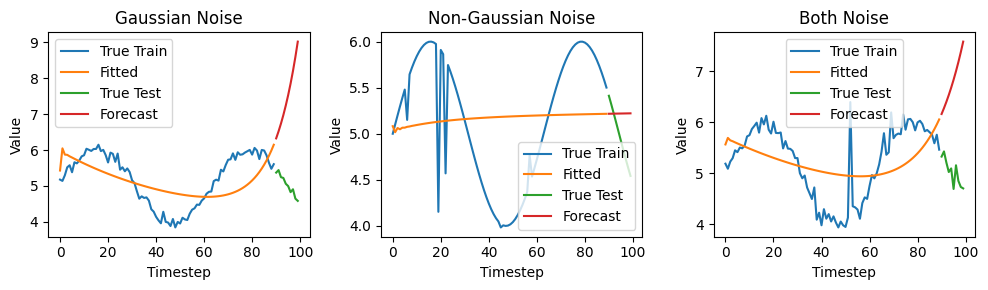

In [4]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 1, 3, 10
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)

datasets = [
  ("Gaussian Noise", toy_datasets.periodical_sinusoidal_with_gaussian_noise().reshape(-1, 1).T), 
  ("Non-Gaussian Noise", toy_datasets.periodical_sinusoidal_with_non_gaussian_noise().reshape(-1, 1).T),
  ("Both Noise", toy_datasets.periodical_sinusoidal_with_both_noise().reshape(-1, 1).T),
]
fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(10, 3))
for i, (title, ds) in enumerate(datasets):
  train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

  alg = Stage4Algorithm(num_elements=num_elements, h_order=20, ar_order=order)
  alg.fit(train_data)
  fitted = alg.X
  forecasted = alg.forecast(fitted, test_len)
  ax[i].plot(range(train_data.shape[1]), train_data.flatten(), label="True Train")
  ax[i].plot(range(train_data.shape[1]), fitted.T, label="Fitted")
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.flatten(), label="True Test")
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
  ax[i].set_xlabel("Timestep")
  ax[i].set_ylabel("Value")
  ax[i].set_title(title)
  ax[i].legend()

  fit_mse = alg.evaluate(train_data, alg.X)
  print(f"{title} fit MSE: ", fit_mse)
  forecast_mse = alg.evaluate(test_data, forecasted)
  print(f"{title} forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

`xtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 1719, CG iterations: 0, optimality: 2.17e-01, constraint violation: 2.22e-16, execution time:  2.1 s.
Gaussian Noise fit MSE:  1.8386506483270055
Gaussian Noise forecast MSE:  0.2881860409797842
`xtol` termination condition is satisfied.
Number of iterations: 16, function evaluations: 1910, CG iterations: 0, optimality: 1.90e-01, constraint violation: 2.22e-16, execution time:  2.4 s.
Non-Gaussian Noise fit MSE:  2.4995651798939704
Non-Gaussian Noise forecast MSE:  1.0145345198259346
`xtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 1719, CG iterations: 0, optimality: 1.19e-01, constraint violation: 2.22e-16, execution time:  1.1 s.
Both Noise fit MSE:  3.151967665484419
Both Noise forecast MSE:  0.6589544018175928


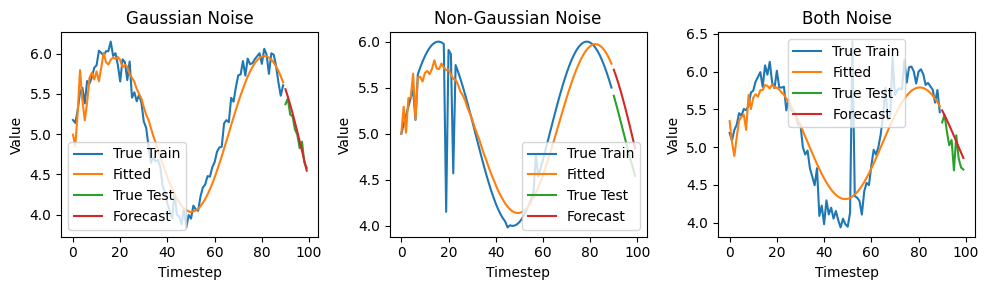

In [5]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 1, 10, 10
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)

datasets = [
  ("Gaussian Noise", toy_datasets.periodical_sinusoidal_with_gaussian_noise().reshape(-1, 1).T), 
  ("Non-Gaussian Noise", toy_datasets.periodical_sinusoidal_with_non_gaussian_noise().reshape(-1, 1).T),
  ("Both Noise", toy_datasets.periodical_sinusoidal_with_both_noise().reshape(-1, 1).T),
]
fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(10, 3))
for i, (title, ds) in enumerate(datasets):
  train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

  alg = Stage4Algorithm(num_elements=num_elements, h_order=20, ar_order=order)
  alg.fit(train_data)
  fitted = alg.X
  forecasted = alg.forecast(fitted, test_len)
  ax[i].plot(range(train_data.shape[1]), train_data.flatten(), label="True Train")
  ax[i].plot(range(train_data.shape[1]), fitted.T, label="Fitted")
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.flatten(), label="True Test")
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
  ax[i].set_xlabel("Timestep")
  ax[i].set_ylabel("Value")
  ax[i].set_title(title)
  ax[i].legend()

  fit_mse = alg.evaluate(train_data, alg.X)
  print(f"{title} fit MSE: ", fit_mse)
  forecast_mse = alg.evaluate(test_data, forecasted)
  print(f"{title} forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

`xtol` termination condition is satisfied.
Number of iterations: 13, function evaluations: 1442, CG iterations: 0, optimality: 2.22e-02, constraint violation: 2.22e-16, execution time:  2.1 s.
Gaussian Noise fit MSE:  0.810196088809098
Gaussian Noise forecast MSE:  0.3938408971950375
`xtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 1648, CG iterations: 0, optimality: 5.26e-02, constraint violation: 2.22e-16, execution time:  2.5 s.
Non-Gaussian Noise fit MSE:  0.7751223875598069
Non-Gaussian Noise forecast MSE:  1.7865803510433917
`xtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 1648, CG iterations: 0, optimality: 3.71e-02, constraint violation: 2.22e-16, execution time:  1.6 s.
Both Noise fit MSE:  2.5237178705223413
Both Noise forecast MSE:  0.694907695571483


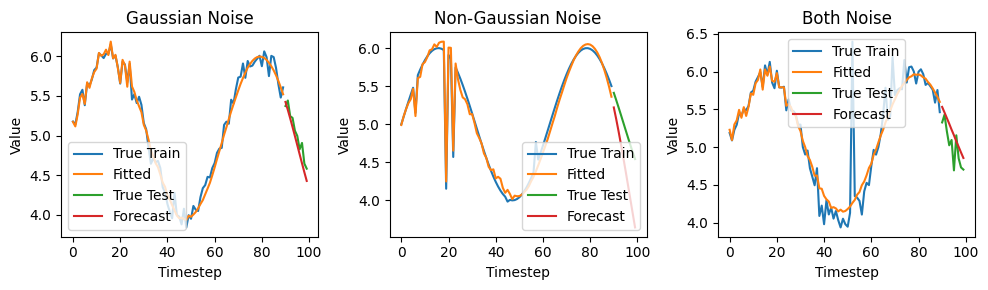

In [14]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 1, 25, 10
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)

datasets = [
  ("Gaussian Noise", toy_datasets.periodical_sinusoidal_with_gaussian_noise().reshape(-1, 1).T), 
  ("Non-Gaussian Noise", toy_datasets.periodical_sinusoidal_with_non_gaussian_noise().reshape(-1, 1).T),
  ("Both Noise", toy_datasets.periodical_sinusoidal_with_both_noise().reshape(-1, 1).T),
]
fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(10, 3))
for i, (title, ds) in enumerate(datasets):
  train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

  alg = Stage4Algorithm(num_elements=num_elements, h_order=20, ar_order=order)
  alg.fit(train_data)
  fitted = alg.X
  forecasted = alg.forecast(fitted, test_len)
  ax[i].plot(range(train_data.shape[1]), train_data.flatten(), label="True Train")
  ax[i].plot(range(train_data.shape[1]), fitted.T, label="Fitted")
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.flatten(), label="True Test")
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
  ax[i].set_xlabel("Timestep")
  ax[i].set_ylabel("Value")
  ax[i].set_title(title)
  ax[i].legend()

  fit_mse = alg.evaluate(train_data, alg.X)
  print(f"{title} fit MSE: ", fit_mse)
  forecast_mse = alg.evaluate(test_data, forecasted)
  print(f"{title} forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

`xtol` termination condition is satisfied.
Number of iterations: 13, function evaluations: 1617, CG iterations: 0, optimality: 2.82e-02, constraint violation: 2.22e-16, execution time:  2.3 s.
Gaussian Noise fit MSE:  0.535988919420599
Gaussian Noise forecast MSE:  0.24353540320046277
`xtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 1848, CG iterations: 0, optimality: 3.21e-02, constraint violation: 2.22e-16, execution time:  2.1 s.
Non-Gaussian Noise fit MSE:  0.2787153452756196
Non-Gaussian Noise forecast MSE:  0.09822716660483197
`xtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 1848, CG iterations: 0, optimality: 9.70e-02, constraint violation: 4.44e-16, execution time:  2.0 s.
Both Noise fit MSE:  2.1286875725805037
Both Noise forecast MSE:  1.4145862140837566


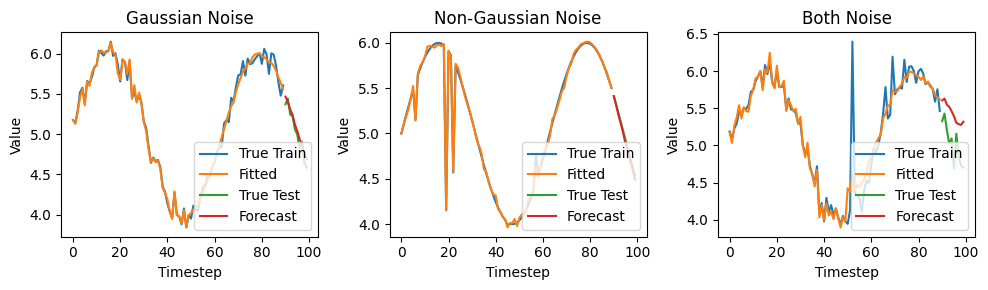

In [11]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 1, 50, 10
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)

datasets = [
  ("Gaussian Noise", toy_datasets.periodical_sinusoidal_with_gaussian_noise().reshape(-1, 1).T), 
  ("Non-Gaussian Noise", toy_datasets.periodical_sinusoidal_with_non_gaussian_noise().reshape(-1, 1).T),
  ("Both Noise", toy_datasets.periodical_sinusoidal_with_both_noise().reshape(-1, 1).T),
]
fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(10, 3))
for i, (title, ds) in enumerate(datasets):
  train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

  alg = Stage4Algorithm(num_elements=num_elements, h_order=20, ar_order=order)
  alg.fit(train_data)
  fitted = alg.X
  forecasted = alg.forecast(fitted, test_len)
  ax[i].plot(range(train_data.shape[1]), train_data.flatten(), label="True Train")
  ax[i].plot(range(train_data.shape[1]), fitted.T, label="Fitted")
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.flatten(), label="True Test")
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
  ax[i].set_xlabel("Timestep")
  ax[i].set_ylabel("Value")
  ax[i].set_title(title)
  ax[i].legend()

  fit_mse = alg.evaluate(train_data, alg.X)
  print(f"{title} fit MSE: ", fit_mse)
  forecast_mse = alg.evaluate(test_data, forecasted)
  print(f"{title} forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

`xtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 1656, CG iterations: 0, optimality: 1.02e-01, constraint violation: 1.11e-16, execution time:  1.3 s.
Financial fit MSE:  37.81710877901402
Financial forecast MSE:  47.673944487514994


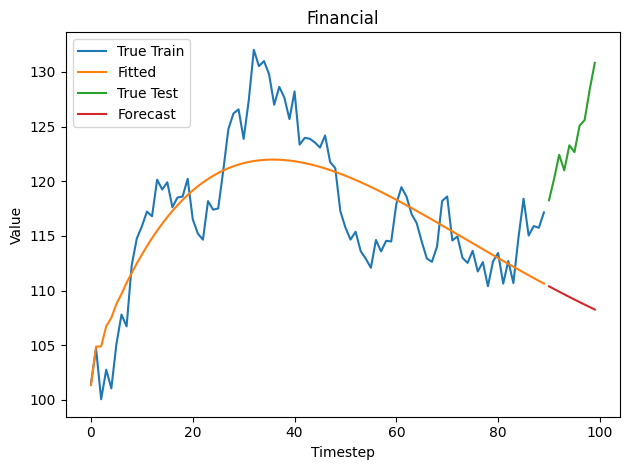

In [6]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 1, 3, 10
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)

title, ds = ("Financial", toy_datasets.financial().reshape(-1, 1).T)

train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

alg = Stage4Algorithm(num_elements=num_elements, h_order=20, ar_order=order)
alg.fit(train_data)
fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.flatten(), label="True Train")
plt.plot(range(train_data.shape[1]), fitted.flatten(), label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.flatten(), label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(title)
plt.legend()

fit_mse = alg.evaluate(train_data, alg.X)
print(f"{title} fit MSE: ", fit_mse)
forecast_mse = alg.evaluate(test_data, forecasted)
print(f"{title} forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

`xtol` termination condition is satisfied.
Number of iterations: 17, function evaluations: 2101, CG iterations: 0, optimality: 7.81e-02, constraint violation: 2.22e-16, execution time:  1.7 s.
Financial fit MSE:  33.89542701105959
Financial forecast MSE:  45.14467706517095


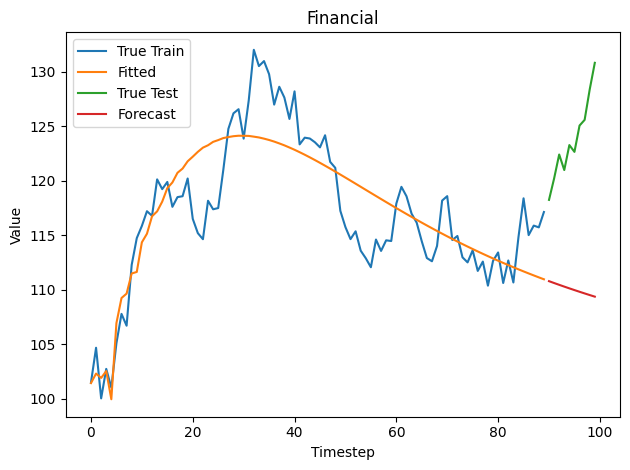

In [27]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 1, 10, 10
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)

title, ds = ("Financial", toy_datasets.financial().reshape(-1, 1).T)

train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

alg = Stage4Algorithm(num_elements=num_elements, h_order=20, ar_order=order)
alg.fit(train_data)
fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.flatten(), label="True Train")
plt.plot(range(train_data.shape[1]), fitted.flatten(), label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.flatten(), label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(title)
plt.legend()

fit_mse = alg.evaluate(train_data, alg.X)
print(f"{title} fit MSE: ", fit_mse)
forecast_mse = alg.evaluate(test_data, forecasted)
print(f"{title} forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

`xtol` termination condition is satisfied.
Number of iterations: 101, function evaluations: 17112, CG iterations: 0, optimality: 1.80e+02, constraint violation: 5.68e-14, execution time:  8.1 s.
Financial fit MSE:  362.4738989739858
Financial forecast MSE:  48.55899299445806


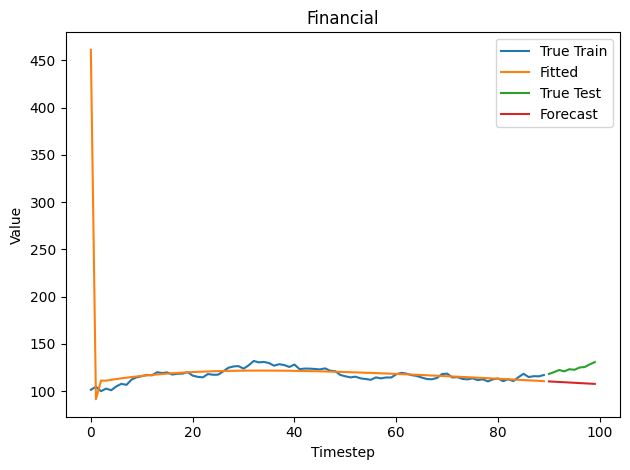

In [7]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 1, 3, 10
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)

title, ds = ("Financial", toy_datasets.financial().reshape(-1, 1).T)

train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

alg = Stage4Algorithm(num_elements=num_elements, h_order=20, ar_order=order, normalize=False)
alg.fit(train_data)
fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.flatten(), label="True Train")
plt.plot(range(train_data.shape[1]), fitted.flatten(), label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.flatten(), label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(title)
plt.legend()

fit_mse = alg.evaluate(train_data, alg.X)
print(f"{title} fit MSE: ", fit_mse)
forecast_mse = alg.evaluate(test_data, forecasted)
print(f"{title} forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()